# Getting and Preprocessing the Data

## Original post: https://jessesw.com/XG-Boost/

I decided a nice dataset to use for this example comes yet again from the UC-Irvine Machine Learning repository. This dataset is the classic “Adult Data Set” https://archive.ics.uci.edu/ml/datasets/Adult. An older set from 1996, this dataset contains census data on income. Our job is to predict whether a certain individual had an income of greater than 50,000 based on their demographic information. In the dataset description found here https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names, we can see that the best model they came up with at the time had an accuracy of 85.95% (14.05% error on the test set). Let’s see if we can beat that, shall we?

First, load in numpy/pandas and download the data, which is split into train/test sets already for us. Make sure to skip a header row in this case or pandas will assume the first row is a header.



In [ ]:
import numpy as np
import pandas as pd

train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) # Make sure to skip a row for the test set

Let’s check our train and test sets for any possible issues.

In [4]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


I notice a few problems immediately:

* We don’t have a column header for our data
* There seem to be some unknown values in the fifth row of the test set (the question marks) we need to deal with
* The target values have periods at the end in the test set but do not in the training set (<=50K. vs. <=50K)

Based on the accompanying dataset description, we can see the column names. Let’s put those in for our train and test first.

In [5]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

Apply these to both dataframes.

In [6]:
train_set.columns = col_labels
test_set.columns = col_labels

Next, let’s check to see if pandas has identified any of these missing values.

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


Hmm. There don’t seem to be any. According to the accompanying notes, the original datasets had 32561 in train and 16281 with test. However, unknowns are included and have been labeled with a question mark (?). The test results documented were done after removing all unknowns. Therefore, to see if we can beat their best results, we need to remove the same unknown rows.

If we do so, we should have 30162 in train and 15060 in test. Let’s see if we can remove all of these unknown rows.

It turns out the question mark was actually entered with a space first. Let’s do a simple test to see what would happen if we dropped all rows that contain an unknown marked with a ‘ ?’.

In [9]:
train_set.replace(' ?', np.nan).dropna().shape

(30162, 15)

In [10]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

These must be our missing rows since the numbers add up now if we drop them. Let’s apply this change to our test and training sets.

In [11]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

Now that we have taken care of the missing value problem, we still have an issue with the target income thresholds being encoded slightly differently in test vs. train. We need these to match up appropriately, so we are going to need to fix either the test or training set to make them match up. Let’s replace all of the ‘<=50K.’ with ‘<=50K’ and the same for ‘>50K.’ with ‘>50K’, so essentially, we are just dropping the periods. This is also encoded with a space so include this in the string. We can use the replace method from pandas to fix this.

In [12]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

Checking the unique values from each set, we can see if they now match.

In [13]:
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

Now these look the same. There is one thing we need to do, however, before applying XGBoost. We need to make sure everything encoded as a string is turned into a variable.

# Applying Ordinal Encoding to Categoricals

Our next step is to use ordinal encoding for the features with a string category since XGBoost (like all of the other machine learning algorithms in Python) requires every feature vector to include only digits. To do this properly, however, we will need to join the two together and apply our encoding so that the same categories exist in both datasets when we do train/test evalulation. There is some debate as to whether you are technically supposed to use one-hot encoding for categorical features (since there isn’t supposed to be any inherent ordering) but I found this discussion https://github.com/szilard/benchm-ml/issues/1 on the subject interesting. It seems that one-hot encoding isn’t necessary for tree-based algorithms, but you may run into a problem using this on linear models. I personally find ordinal encoding is more than sufficient and it significantly reduces your memory footprint if you have quite a few categorical features.

First, combine them together into a single dataset.

In [15]:
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically

combined_set.info()

We can see they are now combined. Next, if the feature is not already numerical, we need to encode it as one. We can use pandas Categorical codes for this task. To make things more simple, I will use a loop to apply this on every feature that isn’t an integer.

In [17]:
for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [18]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


Now that we have all of our features encoded, we need to split these back into their original train/test sizes. Since they haven’t been shuffled we just need to retrieve the same indices as before.

In [19]:
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

We can now finally start playing around with XGBoost.

# Initial Model Setup and Grid Search

We still have our target value inside our train and test frames that needs to be separated from the feature vectors we will be feeding into XGBoost. Let’s get those now.

In [21]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

Now import the libraries we will need to do grid search for XGBoost. Fortunately for those of us used to sklearn’s API, XGBoost is compatible with this, so we can still utilize the traditional GridSearch with XGBoost.

In [22]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/home/cs/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cs/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


To see all of the available parameters that can be tuned in XGBoost, have a look at the parameter documentation https://github.com/dmlc/xgboost/blob/master/doc/parameter.md. This should help you better understand the choices I am making to start off our first grid search. I am going to start tuning on the maximum depth of the trees first, along with the min_child_weight, which is very similar to min_samples_split in sklearn’s version of gradient boosted trees. We set the objective to ‘binary:logistic’ since this is a binary classification problem (although you can specify your own custom objective function if you wish: an example is available here https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py).

In [23]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

Now let’s run our grid search with 5-fold cross-validation and see which parameters perform the best.

In [24]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [25]:
optimized_GBM.grid_scores_

[mean: 0.86685, std: 0.00239, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86659, std: 0.00371, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86725, std: 0.00317, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86178, std: 0.00317, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.85953, std: 0.00251, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86158, std: 0.00239, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85611, std: 0.00330, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85525, std: 0.00323, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85714, std: 0.00320, params: {'max_depth': 7, 'min_child_weight': 5}]

We can see that the first hyperparameter combination performed best and we already beat our target of 85.95% accuracy in our cross-validation! Let’s try optimizing some other hyperparameters now to see if we can beat a mean of 86.78% accuracy. This time, we will play around with subsampling along with lowering the learning rate to see if that helps.

In [26]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [27]:
optimized_GBM.grid_scores_

[mean: 0.86622, std: 0.00271, params: {'subsample': 0.7, 'learning_rate': 0.1},
 mean: 0.86685, std: 0.00239, params: {'subsample': 0.8, 'learning_rate': 0.1},
 mean: 0.86771, std: 0.00349, params: {'subsample': 0.9, 'learning_rate': 0.1},
 mean: 0.85999, std: 0.00307, params: {'subsample': 0.7, 'learning_rate': 0.01},
 mean: 0.86032, std: 0.00272, params: {'subsample': 0.8, 'learning_rate': 0.01},
 mean: 0.86002, std: 0.00282, params: {'subsample': 0.9, 'learning_rate': 0.01}]

No, it doesn’t look like we can improve on this. However, we may be able to optimize a little further by utilizing XGBoost’s built-in cv which allows early stopping to prevent overfitting.

# Early stopping CV

Based on the CV testing performed earlier, we want to utilize the following parameters:

* Learning_rate (eta) = 0.1
* Subsample, colsample_bytree = 0.8
* Max_depth = 3
* Min_child_weight = 1

There are a few other parameters we could tune in theory to squeeze out further performance, but this is a good enough starting point.

To increase the performance of XGBoost’s speed through many iterations of the training set, and since we are using only XGBoost’s API and not sklearn’s anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when you have a very large number of training examples. To create a DMatrix:

In [28]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

Now let’s specify our parameters (with slightly different syntax in some places for the XGBoost native API) and set our stopping criteria. For now, let’s be aggressive with the stopping and say we don’t want the accuracy to improve for at least 100 new trees.

In [30]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

We can look at our CV results to see how accurate we were with these settings. The output is automatically saved into a pandas dataframe for us.

In [31]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
457,0.130173,0.004067,0.116570,0.001104
458,0.130106,0.004026,0.116578,0.001137
459,0.130040,0.003949,0.116520,0.001080
460,0.130073,0.003919,0.116537,0.001141
461,0.129974,0.003961,0.116512,0.001133


Our CV test error at this number of iterations is 12.897%, or 87.103% accuracy.

Now that we have our best settings, let’s create this as an XGBoost object model that we can reference later.

In [32]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

Notice that it trains very quickly. With our XG model object, we can then plot our feature importances using a built-in method. This is similar to the feature importances found in sklearn.

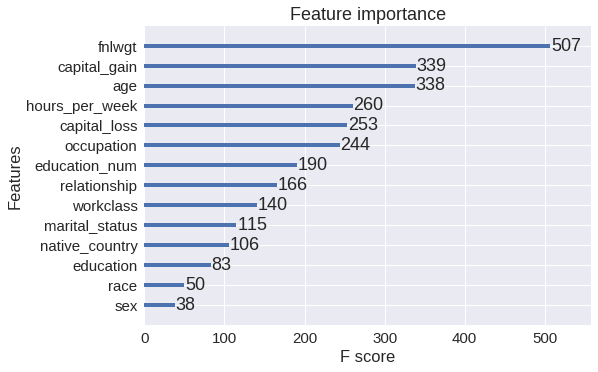

In [35]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

This will tell us which features were most important in the series of trees. The ‘fnlwgt’ feature seems to have the most importance. Filing capital gains was also important, which makes sense given that only those with greater incomes have the ability to invest. Race and sex were not as important. This may be because we are just predicting a specific threshold (below/above 50000 a year) instead of a precise income.

If the built-in feature importance method isn’t what you wanted, you can make your own chart of feature importances using the get_fscore method:

In [36]:
importances = final_gb.get_fscore()
importances

{'age': 338,
 'capital_gain': 339,
 'capital_loss': 253,
 'education': 83,
 'education_num': 190,
 'fnlwgt': 507,
 'hours_per_week': 260,
 'marital_status': 115,
 'native_country': 106,
 'occupation': 244,
 'race': 50,
 'relationship': 166,
 'sex': 38,
 'workclass': 140}

Given this dictionary, we can now make a plot of it ourselves.

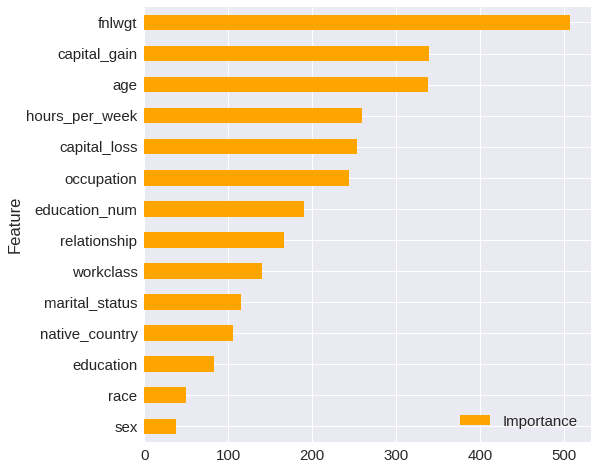

In [37]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

Now that we have an understanding of the feature importances, we can at least figure out better what is driving the splits most for the trees and where we may be able to make some improvements in feature engineering if possible. You can try playing around with the hyperparameters yourself or engineer some new features to see if you can beat the current benchmarks.

# Analyzing Performance on Test Data

The model has now been tuned using cross-validation grid search through the sklearn API and early stopping through the built-in XGBoost API. Now, we can see how it finally performs on the test set. Does it match our CV performance? First, create another DMatrix (this time for the test data).

In [38]:
testdmat = xgb.DMatrix(final_test)

Now let’s use sklearn’s accuracy metric to see how well we did on the test set.

In [40]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([ 0.00303194,  0.20714261,  0.3024281 , ...,  0.82887119,
        0.16432679,  0.78854781], dtype=float32)

You can see that the predict function for XGBoost outputs probabilities by default and not actual class labels. To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.

In [41]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0., ...,  1.,  0.,  1.], dtype=float32)

Now we can calculate our accuracy.

In [42]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.86865869853917665, 0.13134130146082335)

Our final accuracy is 86.94%, or a 13.05% error rate. We beat our goal by a whole percentage point!

There is probably more that we could do to improve this model, such as additional hyperparameter tuning or even some additional feature engineering. However, according to the guidelines of the original data, we beat their best performance. It has been 20 years since the data was originally submitted . . . so we shouldn’t be too surprised!

# Ideas for Improvement and Summary

In this post, we explored some of the basic functionality involving the XGBoost library. We also learned how it works and why it performs faster than other gradient boosting libraries do. As a test, we used it on an example dataset of US incomes, beating the performance of other documented models for the dataset with very little effort. We were also able to investigate feature importances to see which features were influencing the model most.

Possible ideas for using XGBoost in the future:

* Make sure to read the documentation https://xgboost.readthedocs.org/en/latest/ thoroughly if you want to utilize some of its more advanced features
* This is a rapidly evolving library, so additional features may be introduced that affect its functionality
* XGBoost is available in most of the other common languages for data science as well such as Julia and R if those are preferable
* XGBoost can also now be utilized at scale, running on Spark and Flink with the recently released XGBoost4J http://dmlc.ml/2016/03/14/xgboost4j-portable-distributed-xgboost-in-spark-flink-and-dataflow.html

Some other helpful information:

* This YouTube video https://www.youtube.com/watch?v=ufHo8vbk6g4 given by Tong He on XGBoost in detail. This describes the R version, but the API is very similar and there is a lot of great information in here on how XGBoost actually works.
* Here is his slide deck http://www.slideshare.net/ShangxuanZhang/xgboost that covers the same material.
* Another tutorial guide on hyperparameter tuning from Aarshay Jain here http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Personally, I wanted to start using XGBoost because of how fast it is and the great success many Kaggle competition entrants have had with the library so far. I’ve began using it in my own work and have been very pleased with the speed increase. If you have a modeling problem involving structured data, I’d encourage you to give the library a try! Thanks to all of the XGBoost developers and contributors for such a wonderful library.

If you would like the Jupyter Notebook for this blog post, you can find it here http://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/XG_Boost_NB.ipynb.